In [2]:
import numpy as np
import pandas as pd
import os
import csv
from datetime import datetime
from dateutil.parser import parse
import matplotlib as plt
#import geopandas as gpd
import urllib
import zipfile
#import requests
#import nyc_geoclient

%matplotlib inline

## Assign outcome variables for inspections data

#### Contents:

1. Define categories for the outcome assignment
2. Function to assign outcomes
3. Inspect the dataframe to check the assignment is working right
4. Drop duplicate values and export




In [3]:
path = "/projects/18_predicting_igc/shared/data/"

inspections = "enforcement_plumbing_inspections_since_010110.csv"
referrals = "gas_high_risk_1l_utility_referral_since_aug_2016.csv"
complaints = "plumbing_complaints_received_citywide.csv"
violations = "work_without_permit_violation_issued_by_plumbing_unit_since_010110.csv"
text_analysis = "gas_utility_referral_data_text_analysis_since_may_2016.csv"

df = pd.read_csv(path + complaints, encoding='cp1250')  # Put any file where 'inspections' is to open it
#df.head()

# Use encoding='cp1250' for inspections and complaints only

In [4]:
# Drop some columns and rename

df1=df.drop(['Current Complaint Jurisdiction','Year','Month','cnxarraycolumn'],axis=1).copy()
df1.columns = ['priority_code','community_board','address','ZIP','borough','BIN','ID','complaint_category','complaint_category_description',
               'complaint_source','complaint_source_description','date_received','d_date','referral_description',
               'referral_agency_code','complaint_source_description','complaint_reason','disp_code',
               'disp_description','inspector_comments','ECB_violation_number']
df1.head()

,priority_code,community_board,address,ZIP,borough,BIN,ID,complaint_category,complaint_category_description,complaint_source,...,date_received,d_date,referral_description,referral_agency_code,complaint_source_description,complaint_reason,disp_code,disp_description,inspector_comments,ECB_violation_number
0,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,PLUMBING WORK - ILLEGAL/NO PERMIT(ALSO SPRINKL...,B,...,1/4/2010,1/4/2010 0:00,NaN,NaN,NaN,PLUMBING WORK IS ONGOING WITHOUT FILING FOR PE...,A8,ECB VIOLATION SERVED,AS PER INSPECTOR,34806614Z
1,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,PLUMBING WORK - ILLEGAL/NO PERMIT(ALSO SPRINKL...,B,...,1/4/2010,1/4/2010 0:00,NaN,NaN,NaN,PLUMBING WORK IS ONGOING WITHOUT FILING FOR PE...,A8,ECB VIOLATION SERVED,AS PER INSPECTOR,34806618X
2,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1272972,94,PLUMBING-DEFECTIVE/LEAKING/NOT MAINTAINED,A,...,1/4/2010,1/6/2010 0:00,NaN,NaN,NaN,CALLER STATES THE PIPES ARE FROZEN IN THE BEAU...,A8,ECB VIOLATION SERVED,AS PER INSPECTOR,34806710Z
3,B,101,116 JOHN STREET,10038.0,Manhattan,1001126,1273017,66,PLUMBING WORK - ILLEGAL/NO PERMIT(ALSO SPRINKL...,A,...,1/5/2010,1/14/2010 0:00,NaN,NaN,NaN,CALLER IS REPORTING THAT OWNER'S IN FRONT OF A...,D2,COMPLAINT ASSIGNED TO PLUMBING UNIT,REFERRED TO DOB PLUMBING UNIT,NaN
4,B,101,116 JOHN STREET,10038.0,Manhattan,1001126,1273017,66,PLUMBING WORK - ILLEGAL/NO PERMIT(ALSO SPRINKL...,A,...,1/5/2010,4/6/2010 0:00,NaN,NaN,NaN,CALLER IS REPORTING THAT OWNER'S IN FRONT OF A...,I2,NO VIOLATION WARRANTED FOR COMPLAINT AT TIME O...,NO VIOLATIONS WARRANTED FOR COMPLAINT AT TIME ...,NaN


In [5]:
df1.columns

Index(['priority_code', 'community_board', 'address', 'ZIP', 'borough', 'BIN',
       'ID', 'complaint_category', 'complaint_category_description',
       'complaint_source', 'complaint_source_description', 'date_received',
       'd_date', 'referral_description', 'referral_agency_code',
       'complaint_source_description', 'complaint_reason', 'disp_code',
       'disp_description', 'inspector_comments', 'ECB_violation_number'],
      dtype='object')

In [6]:
df1.d_date = pd.to_datetime(df1.d_date)
df1.date_received = pd.to_datetime(df1.date_received)

#### 1. Define categories for the outcome assignment
Problem categories (prob_cats) should be violations and stop work orders (including partial)

As discussed with Qing, decision rule is: assign 'problem' category if a violation or stop work order is ever present during one of the inspectors visits (regardless of any subsequent rescindment)


In [7]:
# Make a key of the disposition codes

key = df1[['disp_code','disp_description']].drop_duplicates(subset='disp_code').copy()
key.sort_values('disp_code',inplace=True)
key

,disp_code,disp_description
71,A1,BUILDINGS VIOLATION(S) SERVED
6,A3,FULL STOP WORK ORDER SERVED ...
0,A8,ECB VIOLATION SERVED
320,A9,ECB & BUILDINGS VIOLATIONS SERVED
647,B1,BUILDINGS VIOLATION(S) PREPARED & ATTEMPT TO S...
79,B2,ECB VIOLATION(S) PREPARED & ATTEMPT TO SERVE W...
12,C1,INSPECTOR UNABLE TO GAIN ACCESS - 1ST ATTEMPT
13,C2,INSPECTOR UNABLE TO GAIN ACCESS - 2ND ATTEMPT
371,C3,ACCESS DENIED - 1ST ATTEMPT
535,C4,ACCESS DENIED - 2ND ATTEMPT


In [8]:
# Define categories

prob_cats = {'A1','A3','A8','A9','B1','B2','D5','ND','L1','Y1','Y3'}
no_violation = {'I1','I2','P5','R1'}

all_cats = set(df1.disp_code.unique())

In [21]:
remaining_cats = all_cats - prob_cats - no_violation
print("After problem_cats and no_violation, there are {} remaining categories, namely: ".format(len(remaining_cats)))
remaining_cats

After problem_cats and no_violation, there are 29 remaining categories, namely: 


{'C1',
 'C2',
 'C3',
 'C4',
 'D1',
 'D2',
 'D3',
 'D4',
 'D6',
 'E1',
 'E6',
 'E8',
 'F1',
 'F3',
 'F6',
 'F8',
 'G2',
 'G6',
 'G7',
 'H1',
 'H3',
 'J1',
 'K1',
 'K2',
 'L2',
 'L3',
 'WD',
 'XX',
 'Y2'}

In [26]:
# Show an outcome key

pd.DataFrame({"Outcome assigned":[0,1,2],"Meaning":['No entry','No violation warranted','Violation / stop work order']})

,Meaning,Outcome assigned
0,No entry,0
1,No violation warranted,1
2,Violation / stop work order,2


#### 2. Function to assign outcomes

In [95]:
def assign_outcomes(comp_data):
    
    '''Function to assign outcome values for a complaint ID.
    
    Takes a chunk of a pandas dataframe (feed in one complaint ID at a time).
    Puts all the unique disposition codes into a variable 'true_cats.' Then:
    
    - First checks whether any of the codes listed in 'problem_cats' is present, returning 2 if that's the case.
    - Then checks whether any of the 'no_violation' codes is present, returning 1 if that's the case.
    - Otherwise, returns 0 indicating no access to the address.
    
    Returns the value assigned for this complaint ID.
    '''
    
    true_cats = set(comp_data.disp_code.unique())
    if true_cats & prob_cats:
        return 2
    elif true_cats & no_violation:
        return 1
    else:
        return 0

In [111]:
sample_ID = df1[df1.ID==4544445]
sample_ID[sample_ID.disp_code.isin(prob_cats)].d_date.max()

Timestamp('2016-03-04 00:00:00')

In [114]:
# We need to get the most recent date for an inspection 
# Currently just gives the last inspection date
# Could add some more logic in: eg last date where \
# outcome was 1 or 2 (assuming 1 or 2 were present)

def assign_dates(comp_data):
    ''' 
    If outcome is 'problem', return the first inspection date where a problem was identified.
     
     --> note this removes any 'violation rescinded' date and just gives the date
         when a violation or stop work order was first issued
  
    Else return last inspection date.
    '''
    
    true_cats = set(comp_data.disp_code.unique())
    
    if true_cats & prob_cats:
        return comp_data[comp_data.disp_code.isin(prob_cats)].d_date.min()

    else:
        return(comp_data.d_date.max())


In [127]:
# Using the assign_outcomes function, create a dictionary with each inspection ID and its outcome.

outcomes = {}
for i in df1.ID.unique():
    outcomes[i] = assign_outcomes(df1[df1.ID == i])

# Map the outcomes to the whole dataframe
df1['outcomes'] = df1.ID.map(outcomes)

In [128]:
# Same with the assign_dates function

last_insp_dates = {}
for i in df1.ID.unique():
    last_insp_dates[i] = assign_dates(df1[df1.ID == i])

# Map the outcomes to the whole dataframe
df1['insp_date'] = df1.ID.map(last_insp_dates)

#### 3. Inspect the dataframe to check the assignment is working right
Use the code below to check any of the complaint IDs, especially those with large numbers of records.
Make any more corrections to the function if needed.


In [126]:
## Identify the complaints with the largest number of inspection records
## Inspect them to check we're assigning outcomes correctly

a=df1[df1.disp_code.isin(['L1','L2'])].groupby('ID').count().copy()
top_complaints=list(a.sort_values('BIN',ascending=False).head(400).index)

# Which one to inspect
inspect = 18   # check 304

# Show the complaint transactions

#df1[['date_received','d_date']][df1.ID == top_complaints[inspect]]

df1[['d_date','inspector_comments','disp_code','disp_description','outcomes','insp_date']][df1.ID == top_complaints[inspect]]

,d_date,inspector_comments,disp_code,disp_description,outcomes,insp_date
6521,2016-05-19,NEW VIOLATIONS ISSUED,A8,ECB VIOLATION SERVED,2,2016-05-19
6522,2016-05-19,NEW VIOLATIONS ISSUED,A8,ECB VIOLATION SERVED,2,2016-05-19
6523,2016-05-19,FALSIFYING DOCUMENTS AND FAILURE TO MAINTAIN B...,L1,PARTIAL STOP WORK ORDER ...,2,2016-05-19
6524,2016-05-19,FALSIFYING DOCUMENTS AND FAILURE TO MAINTAIN B...,L1,PARTIAL STOP WORK ORDER ...,2,2016-05-19
6525,2016-08-08,SWO FULLY RESCINDED. ALL WORK APPROVED UNDER #...,L2,STOP WORK ORDER FULLY RESCINDED ...,2,2016-05-19
6526,2016-08-08,SWO FULLY RESCINDED. ALL WORK APPROVED UNDER #...,L2,STOP WORK ORDER FULLY RESCINDED ...,2,2016-05-19


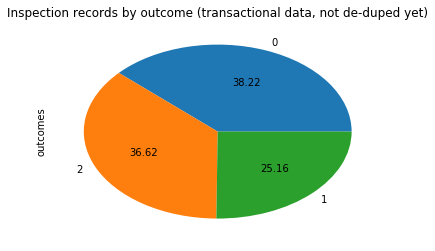

In [129]:
df1['outcomes'].value_counts().plot(kind='pie',title='Inspection records by outcome (transactional data, not de-duped yet)',autopct='%.2f')

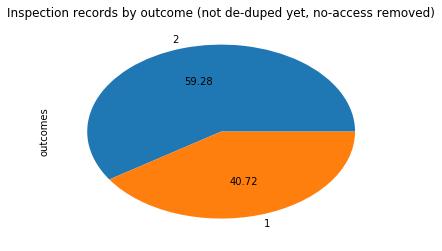

In [130]:
df1['outcomes'][df1.outcomes != 0].value_counts().plot(kind='pie',title='Inspection records by outcome (not de-duped yet, no-access removed)',autopct='%.2f')

#### 4. Drop duplicate values and export

In [131]:
df_clean = df1.drop_duplicates(subset='ID').copy()

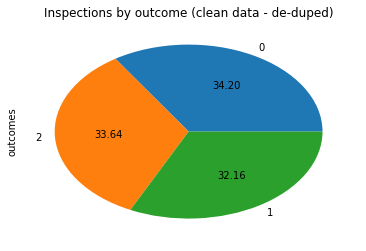

In [132]:
df_clean['outcomes'].value_counts().plot(kind='pie',title='Inspections by outcome (clean data - de-duped)',autopct='%.2f')

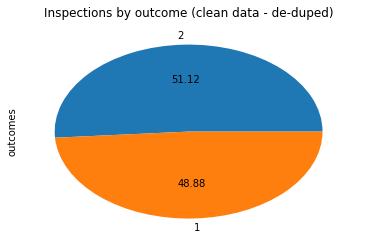

In [133]:
df_clean['outcomes'][df_clean.outcomes != 0].value_counts().plot(kind='pie',title='Inspections by outcome (clean data - de-duped)',autopct='%.2f')

In [134]:
df_clean.shape

(25716, 23)

In [136]:
df_clean.to_csv(path + 'inspections_master_v1_1.csv',encoding='utf8')